Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
import numpy as np
from itertools import product
import random
from collections import defaultdict
from tqdm import tqdm
from collections import Counter
import seaborn as sns



In [2]:
class TicTacToe():
    def __init__(self,player = 'X',reward_type ='goal_reward'):
        '''
        player: Role agent should play. If X, agent has the first turn else agent has second turn
        reward_type: 'goal_reward' or 'action_penalty'
        '''
        self.board = np.array(['__']*9).reshape(3,3)
        self.reward_type = reward_type
        self.winning_seqeunce = None #Keep track of winning move made by agent
        self.first_move = None #Keep track of first move made by agent
        if player == 'X':
            self.me ='X'
            self.id = 1
            self.opponent = 'O'
        else:
            self.me = 'O'
            self.id = 2
            self.opponent = 'X'
     
        self.game_over = False #Flag indicating whether game is over
        # Mapping of action representation in board to action representation in tuple 
        self.b_to_s = {'__':0,'X':1,'O':2} 
        # Mapping of action representation in tuple to action representation in board
        self.s_to_b = {0:'__',1:'X',2:'O'} 
        
        #Create mapping from 2D position in board to 1D position in tuple
        positions = self.available_positions()
        self.b2_to_s1 = {position:i for (i,position) in enumerate(positions)}
        
        #Create mapping from 1D position in tuple to 2D position in board 
        self.s1_to_b2 = {i:position for (i,position) in enumerate(positions)}
        
        #State the current player is in
        self.starting_state = self.board_to_state()
        
        #Initialize all possible states of the game
        l_o_l = [list(range(3)) for _ in range(9)]
        states = set(product(*l_o_l))
        

        
        #Player X states include states with odd number of blanks and both players have occupied equal number of slots
        #Player O players after Player X, so player O states include states with even number of blanks and where
        #player X has occupied one more slot than player O
        playerX_states = {state for state in states if (state.count(0)%2 == 1 and state.count(1)==state.count(2))} #
        playerO_states =  {state for state in states if (state.count(0)%2 == 0 and state.count(1)==(state.count(2)+1))}
        
        #States 
        #self.board_full_states = {state for state in states if state.count(0)==0}
        if player == 'X':
            self.my_states = playerX_states
        else:
            self.my_states = playerO_states
          
    
    def reset_board(self):
        "Function to reset game and reset board to starting state"
        self.board = np.array(['__']*9).reshape(3,3)
        self.starting_state = self.board_to_state()
        self.game_over = False
        self.winning_sequence = None
        self.first_move = None
    
    def show_board(self):    
        "Shows board as a pandas dataframe"
        return pd.DataFrame(self.board)
    
    def board_to_state(self):
        "Convert a board to a state in tuple format"
        return tuple([self.b_to_s[x] for x in np.ravel(self.board)])
    
    @staticmethod
    def possible_actions(state):
        "Return possible actions given a state"
        return [i for i,x  in enumerate(state) if x ==0]
    

        
    def is_game_over(self):
        "Function to check if game is over"
        if not np.any(self.board == '__') :
            self.game_over = True
            
        return self.game_over
    
    def available_positions(self):
        "Return available positions on the board"
        x,y = np.where(self.board =='__')
        return[(x,y) for x,y in zip(x,y)]
    
    
    def win(self,player):
        "Check if player won the game and record the winning sequence"
        if np.all(self.board[0,:] == player):
            self.winning_sequence = 'R1'
        elif np.all(self.board[1,:] == player): 
            self.winning_sequence = 'R2'
        elif np.all(self.board[2,:] == player):
            self.winning_sequence = 'R3'
        elif np.all(self.board[:,0] == player):
            self.winning_sequence = 'C1'
        elif np.all(self.board[:,1] == player):
            self.winning_sequence = 'C2'
        elif np.all(self.board[:,2] == player):
            self.winning_sequence = 'C3'
        elif np.all(self.board.diagonal()==player):
            self.winning_sequence = 'D1'
        elif  np.all(np.fliplr(self.board).diagonal()==player):
            self.winning_sequence = 'D2'
        else:
            return False
        
        return True
    
    
    def my_move(self,position):
        "Fills out the board in the given position with the action of the agent"
        
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.me
        
        I_win = self.win(self.me)
        opponent_win = self.win(self.opponent)
        
        if self.reward_type == 'goal_reward':
            if I_win:
                self.game_over = True
                return 1
            
            elif opponent_win:
                self.game_over = True
                return -1
            
            else:
                return 0
            
        elif self.reward_type == 'action_penalty':
            if I_win:
                self.game_over = True
                return 0
            
            elif opponent_win:
                self.game_over = True
                return -10
            
            else:
                return -1
    
    def opponent_move(self,position):
        "Fills out the board in the given position with the action of the opponent"
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.opponent
            
    
    def pick_best_action(self,Q,action_type,eps=None):
        '''Given a Q function return optimal action
        If action_type is 'greedy' return best action with ties broken randomly else return epsilon greedy action
        '''
        #Get possible actions
        current_state = self.board_to_state()
        actions =  self.possible_actions(current_state)
        
        best_action = []
        best_action_value = -np.Inf
        
        for action in actions:
            Q_s_a = Q[current_state][action]
            if Q_s_a == best_action_value:
                best_action.append(action)
            elif Q_s_a > best_action_value:
                best_action = [action]
                best_action_value = Q_s_a
        best_action = random.choice(best_action)

        if action_type == 'greedy':
            return self.s1_to_b2[best_action]
        else:
            assert eps != None , "Include epsilon parameter"
            n_actions =len(actions) #No of legal actions 
            p = np.full(n_actions,eps/n_actions)
            #Get index of best action
            best_action_i = actions.index(best_action)
            p[best_action_i]+= 1 - eps
            return self.s1_to_b2[np.random.choice(actions,p=p)]
    

In [3]:
def play_games(n_games, Q_X, Q_O, X_strategy='eps_greedy', O_strategy='eps_greedy', eps_X=0.05, eps_O=0.05, seed=1):
    np.random.seed(seed)
    win_stats = defaultdict(int)
    winning_X_first_actions = []
    winning_O_first_actions = []

    t_board_X = TicTacToe(player='X', reward_type='action_penalty')
    t_board_O = TicTacToe(player='O', reward_type='action_penalty')

    for i in tqdm(range(n_games), position=0, leave=True):
        first_action_flag = True
        while True:
            x_action = t_board_X.pick_best_action(Q_X, action_type=X_strategy, eps=eps_X)
            if first_action_flag:
                winning_X_first_actions.append(x_action)

            t_board_X.my_move(x_action)
            t_board_O.opponent_move(x_action)

            if t_board_X.is_game_over():
                break

            o_action = t_board_O.pick_best_action(Q_O, action_type=O_strategy, eps=eps_O)
            if first_action_flag:
                winning_O_first_actions.append(o_action)
                first_action_flag = False

            t_board_O.my_move(o_action)
            t_board_X.opponent_move(o_action)

            if t_board_O.is_game_over():
                break

        if t_board_X.win('X'):
            win_stats['X_win'] += 1
        elif t_board_X.win('O'):
            win_stats['O_win'] += 1
        else:
            win_stats['Draw'] += 1

        t_board_X.reset_board()
        t_board_O.reset_board()

    # Find the most frequent initial winning moves for each player
    most_common_X = Counter(winning_X_first_actions).most_common(1)
    most_common_O = Counter(winning_O_first_actions).most_common(1)

    return win_stats, most_common_X[0][0] if most_common_X else None, most_common_O[0][0] if most_common_O else None



In [4]:
def initialize_Q(S,seed = 1):
    "Given a state assign random values to each possible action"
    np.random.seed(seed)
    Q = {}
    for state in S:
        Q[state]= {}
        for i,x  in enumerate(state): # Loop through action
            if x == 0:
                Q[state][i] = 0
    
    return Q

def moving_average(x, w):
    "Function to calculate moving average of rewards"
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
def train(n_games=1000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False,is_random=True,**kwargs):
    """
    Function to train a player in a game of tic-tac-toe
    Arguments:
        n_games: Number of games on which to train
        alpha: Learning rate
        gamma: discount factor
        train_X: Flag indicating whether player X should be trained
        train_O: Flag inficating whether player O should be trained
        is_random: should actions of untrained agent be random or deterministic according to Q table
    
    """
     
    
    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        Q_O = initialize_Q(States_O)
    
    
    #Set epsilon value conditional on whether we are training X or O
    eps_ = lambda flag,i: 0.05*0.99**i if flag else 1.0
    
    
    #Lists to keep track of rewards earned by both players during training
    
    rewards_X = []
    rewards_O = []
    
    
    if train_X:
        X_action_type = 'eps_greedy'
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'
        
            
    
    if train_O:
        O_action_type = 'eps_greedy'
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'
            
    for i in tqdm(range(n_games),position=0,leave=True):
        
        eps = 0.05*0.99**i
        t_board_X.reset_board()
        t_board_O.reset_board()

        #X lands on empty board
        S_X = t_board_X.board_to_state()
        
        #X plays first
        eps = eps_(train_X,i)
        
            
        x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]
        
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()
            
            #O plays second
            eps = eps_(train_O,i)
            
            
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_action_type,eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board
            if  t_board_O.is_game_over(): 
                #need to end game here if O makes the winnng move and add a reward 
                if train_O:
                    Q_O[S_O][o_action1d] += alpha*(R_O + 0 - Q_O[S_O][o_action1d]) # 0 given value of terminal state is 0
                
                if train_X:
                #Need to penalize X's previous action if game is over
                    Q_X[S_X][x_action1d] += alpha*(-R_O + 0 - Q_X[S_X][x_action1d]) 
                
                rewards_O.append(R_O)
                rewards_X.append(-R_O)
                break
            
            S_X_new = t_board_X.board_to_state() #Get new state
            #Calculate max_a Q_X(S',a)
            if train_X:
                x_action_ = t_board_X.pick_best_action(Q_X,action_type = 'greedy',eps=0.05) #best action from S_new
                x_action_1d = t_board_X.b2_to_s1[x_action_]
                Q_X[S_X][x_action1d]+= alpha*(R_X + gamma*Q_X[S_X_new][x_action_1d] - Q_X[S_X][x_action1d])
        
            S_X = S_X_new
    
            

            # X plays next
            eps = eps_(train_X,i)
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board

            if t_board_X.is_game_over(): 
                if train_O:
                    #need to end game here if X makes the winning move and make sure O's action is penalized
                    Q_O[S_O][o_action1d] += alpha*(-R_X + 0 - Q_O[S_O][o_action1d]) #0 given value of terminal state is 0
                
                if train_X:
                    #need to end game here if X makes the winning move and make sure reward is added to V
                    Q_X[S_X][x_action1d] += alpha*(R_X + 0 - Q_X[S_X][x_action1d]) #0 given value of terminal state is 0
                
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break   


            S_O_new = t_board_O.board_to_state() #Get new state
            #Calculate max_a Q_O(S',a)
            if train_O:
                o_action_ = t_board_O.pick_best_action(Q_O,action_type = 'greedy',eps=0.05) #best action from S_new
                o_action_1d = t_board_O.b2_to_s1[o_action_]
                Q_O[S_O][o_action1d]+= alpha*(R_O + gamma*Q_O[S_O_new][o_action_1d] - Q_O[S_O][o_action1d])

            S_O = S_O_new
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
        
        
    return Q_X,Q_O,rewards_X,rewards_O

In [6]:
# init

t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')

States_X = t_board_X.my_states
States_O = t_board_O.my_states

Q_X = initialize_Q(States_X)
Q_O = initialize_Q(States_O)


In [7]:
## Random X vs Random O
#by setting X and O to eps greedy and epsilon=1 we ensure that the agents only play random moves


n_games = 1000

result, initial_winning_move_X, initial_winning_move_O = play_games(n_games, Q_X, Q_O, X_strategy='eps_greedy', O_strategy='eps_greedy', eps_X=1, eps_O=1)

print("X Win Rate:", result['X_win']/n_games*100,'%')
print("O Win Rate:", result['O_win']/n_games*100,'%')
print("Draws Rate:", result['Draw']/n_games*100,'%')

print("Best Starting Move of X:", initial_winning_move_X)
print("Best Starting Move of O:", initial_winning_move_O)

  2%|▏         | 22/1000 [00:00<00:04, 215.67it/s]

100%|██████████| 1000/1000 [00:03<00:00, 315.75it/s]

X Win Rate: 61.6 %
O Win Rate: 28.4 %
Draws Rate: 10.0 %
Best Starting Move of X: (1, 1)
Best Starting Move of O: (1, 1)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 484.19it/s]


X Win Rate: 94.39999999999999 %
O Win Rate: 0.0 %
Draws Rate: 5.6000000000000005 %
Favorite Starting Move of X: (2, 2)
Favorite Starting Move of O: (1, 1)


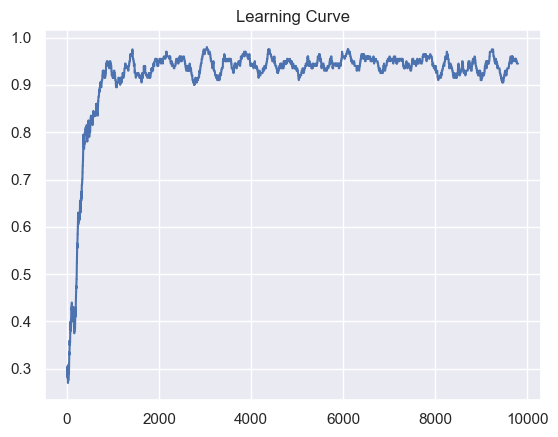

In [15]:
# X Trained with random O vs random O

np.random.seed(1)

Q_X,_,rewards_X,rewards_O = train(n_games=10000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False,is_random=True)
Q_X_trained = Q_X

n_games=1000
result, initial_winning_move_X, initial_winning_move_O = play_games(n_games, Q_X_trained, Q_O, X_strategy='greedy', O_strategy='eps_greedy', eps_X=1, eps_O=1)

print("X Win Rate:", result['X_win']/n_games*100,'%')
print("O Win Rate:", result['O_win']/n_games*100,'%')
print("Draws Rate:", result['Draw']/n_games*100,'%')

print("Favorite Starting Move of X:", initial_winning_move_X)
print("Favorite Starting Move of O:", initial_winning_move_O)

100%|██████████| 1000/1000 [00:02<00:00, 430.45it/s]


X Win Rate: 1.3 %
O Win Rate: 87.1 %
Draws Rate: 11.600000000000001 %
Favorite Starting Move of X: (2, 0)
Favorite Starting Move of O: (1, 1)


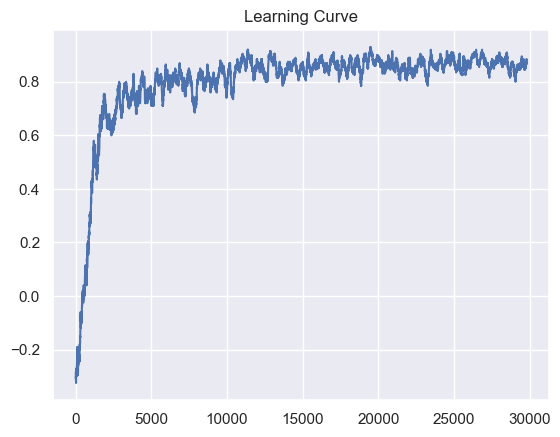

In [17]:
#Random X vs O Trained with random X
#again eps set to 1 and eps greedy for x player this time
np.random.seed(1)
_,Q_O,rewards_X,rewards_O = train(n_games=30000,alpha = 0.35, gamma = 0.9,train_X=False,train_O=True,is_random=True)
Q_O_trained = Q_O

n_games=1000
result, initial_winning_move_X, initial_winning_move_O = play_games(n_games,Q_X,Q_O_trained,X_strategy = 'eps_greedy',O_strategy='greedy',eps_X=1.0,
                   eps_O=1.0)

print("X Win Rate:", result['X_win']/n_games*100,'%')
print("O Win Rate:", result['O_win']/n_games*100,'%')
print("Draws Rate:", result['Draw']/n_games*100,'%')

print("Favorite Starting Move of X:", initial_winning_move_X)
print("Favorite Starting Move of O:", initial_winning_move_O)

In [10]:
# Trained X vs Trained O (both trained agaist random)
#both greedy, eps are irrelevant due to the qtables already trained
n_games=1000
result, initial_winning_move_X, initial_winning_move_O = play_games(n_games,Q_X_trained,Q_O_trained,X_strategy = 'greedy',O_strategy='greedy')

print("X Win Rate:", result['X_win']/n_games*100,'%')
print("O Win Rate:", result['O_win']/n_games*100,'%')
print("Draws Rate:", result['Draw']/n_games*100,'%')

print("Favorite Starting Move of X:", initial_winning_move_X)
print("Favorite Starting Move of O:", initial_winning_move_O)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 374.98it/s]

X Win Rate: 0.0 %
O Win Rate: 0.0 %
Draws Rate: 100.0 %
Favorite Starting Move of X: (2, 2)
Favorite Starting Move of O: (0, 0)


100%|██████████| 1000/1000 [00:02<00:00, 450.95it/s]


X Win Rate: 100.0 %
O Win Rate: 0.0 %
Draws Rate: 0.0 %
Favorite Starting Move of X: (2, 1)
Favorite Starting Move of O: (0, 2)


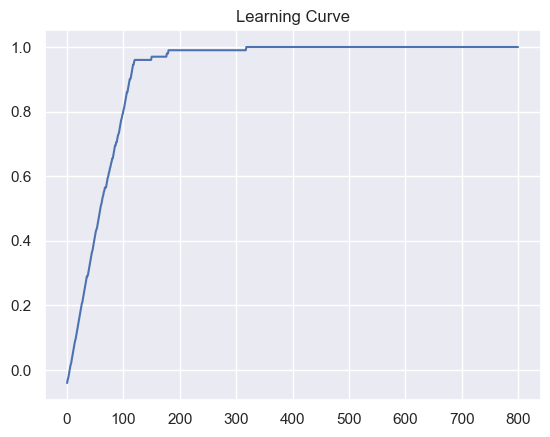

In [12]:
np.random.seed(1)
Q_X,Q_O,rewards_X,rewards_O = train(n_games=1000,alpha = 0.2, gamma = 0.1,train_X=True,train_O=False,is_random=False,Q_O = Q_O_trained)
Q_X_retrained = Q_X
result, initial_winning_move_X, initial_winning_move_O = play_games(n_games,Q_X_retrained,Q_O,X_strategy = 'greedy',O_strategy='greedy', eps_X=1.0, eps_O=1.0)

print("X Win Rate:", result['X_win']/n_games*100,'%')
print("O Win Rate:", result['O_win']/n_games*100,'%')
print("Draws Rate:", result['Draw']/n_games*100,'%')

print("Favorite Starting Move of X:", initial_winning_move_X)
print("Favorite Starting Move of O:", initial_winning_move_O)